In [1]:
import pyarrow.feather as feather
import pandas as pd
from src.utils import *
import numpy as np

# Scoring Methods for Game Path Analysis  

***Prioritizing Scores Based on Minimal Clicks*** 

### **Difference Between Played Path Length and Optimal Distance**  
- **Optimal Distance**: The shortest possible distance from the start to the target article.  
- **Played Path Length**: The actual number of clicks (or visited articles - 1). This is represented in the dataset as `simplified_path_length`.  
- Why use `simplified_path_length` instead of `full_path_length`?  
  Simplified paths eliminate detours, thus only the articles relevant in finishing the path are taken into account.

We define the **Path Score** for a completed path as:  
$$
\mathbf{Path\ Score} = \frac{\text{Optimal\ Distance}}{\text{Simplified\ Path\ Length}}
$$  

This score ranges from 0 to 1, where 1 indicates the closest adherence to the optimal path. We refer to this score as the **path weight**, representing the ratio of actual path length to optimal distance.

#### **Article Scoring Based on Path Weights**  
After computing path weights for all completed paths, we use them to derive article scores using two approaches:

1. **Weighted Average**  
   Compute the average path weight for each article across all paths it appears in:  
   $$
   \mathbf{Article\ Score} = \frac{\sum_{i=1}^n w_i}{n}
   $$  
   where  $w_1, w_2, \dots, w_n$ are the path weights, and  $n$ is the number of paths the article appears in.  
   - This score is about article quality over quantity.
   - Only articles with a minimum appearance threshold are included to ensure meaningful scores.  
   - **Function**: `calculate_avg_article_weights(df, count_cutoff=30, scaling=None)`  

2. **Sum of Centered Weights**  
   - **Centering**: First, compute the mean article weight across all paths:  
     $$
     \text{Mean\ Article\ Weight} = \frac{\sum_{i=1}^N (\text{path}_i\ \text{weight} \times \text{num\_artcicles\_in\_path}_i)}{\sum_{i=1}^N \text{num\_artcicles\_in\_path}_i}
     $$  
     where $N$ is the total number of paths (or a downsampled subset), and $\text{num\_artcicles\_in\_path}_i$ the number of articles in simplified path $i$ (without start and target article).

   - **Centered Weights**:  
     $$
     \mathbf{Centered\ Weight} = \mathbf{Path\ Score} - \text{Mean\ Article\ Weight}
     $$  
     Why center using article weight and not path weight? Because in the end, we are interested in computing article weights, and since paths don't have the same number of articles, the average path weight is not the same as the average article weight.

   - Compute the article score by summing all centered weights for the paths the article appears in:  
     $$
     \mathbf{Article\ Score} = \sum_{i=1}^n cw_i
     $$  
     where $cw_1, cw_2, \dots, cw_n$ are the centered weights.  
   - This score balances quality and usefulness within the game.  
   - Only articles with a minimum appearance threshold are included to ensure meaningful scores.  
   - **Function**: `calculate_sum_article_cweights(df, count_cutoff=30, scaling=None)`

---

## Scores Based on Article Appearance in Detours  

### **Detour Ratio**  
- Detours occur when articles are backtracked (i.e don't appear in simplified paths).  
- For each article  $i$, the **Detour Ratio** is:  
  $$
  \mathbf{DetourRatio_i} = \frac{\text{detour\_count}_i}{\text{total\_appearances}_i},
  $$  

  where the $\text{detour\_count}_i$ and $\text{total\_appearances}_i$ are the number of appearance in detours and total number of apperances for article $i$ respectively.
- Only articles with a minimum total appearance threshold are considered.  
- **Function**: `calculate_detour_ratios(df, count_cutoff=30, scaling=None)`  

---

## Scores Based on Article Presence in Unfinished Paths  

### **Unfinished Ratio**  
- Measures how frequently an article appears in incomplete paths.  
- For each article $i$, the **Unfinished Ratio** is:  
  $$
  \mathbf{UnfinishedRatio_i} = \frac{\text{unfinished\_count}_i}{\text{total\_appearances}_i}
  $$  
- Again, articles must meet a minimum appearance threshold for meaningful scores.  
- **Function**: `calculate_unfinished_ratios(df, count_cutoff=30, scaling=None)`  

**========================================================================================================================================**



***Now Consider Scores That Reward Finishing the Game as Fast as Possible***

### **Weighted Average of Article Speed**  
We first compute **path speed**, defined as the time taken to complete the path (from `durationInSec`) divided by `full_path_length`. Similar to the weighted average of path weights, we can compute the average speed for each article. This involves extracting all $n$ paths an article appears in and calculating the average of the associated path speeds $s_1, s_2, \dots, s_n$:  
$$
\mathbf{Article\ Speed} = \frac{\sum_{i=1}^n s_i}{n}
$$  

Where $s_1, s_2, \dots, s_n$ are the path speeds, and $n$ is the number of paths containing the article.  

- Only articles with a minimum total appearance threshold are included for meaningful scores.  
- **Function**: `calc_avg_article_speed(df, count_cutoff=30, scaling=None)`  

---

### **Sum of Centered Article Speed**  
This approach mirrors the **sum of centered weights** but uses **path speed** instead of path weight.  

1. **Centering**: Compute the mean path speed across all paths:  
   $$
   \text{Mean\ Path\ Speed} = \frac{\sum_{i=1}^N (\text{path}_i\ \text{speed} \times \text{full\_path\_length}_i)}{\sum_{i=1}^N \text{full\_path\_length}_i}
   $$  
   where $N$ is the total number of paths (or a downsampled subset).  

2. **Centered Speeds**:  
   $$
   \mathbf{Centered\ Speed} = \mathbf{Path\ Speed} - \text{Mean\ Path\ Speed}
   $$  

3. Compute the article score by summing all centered speeds for the paths the article appears in:  
   $$
   \mathbf{Article\ Score} = \sum_{i=1}^n cs_i
   $$  
   where $cs_1, cs_2, \dots, cs_n$ are the centered speeds, and $n$ is the number of paths the article appears in.  

- This score provides a balance between speed quality and frequency of appearance.  
- **Function**: `calc_sum_article_cspeed(df, count_cutoff=30, scaling=None)`  

---  
***Imporant note about the scaling***  
The functions are all coded in a way that when scaling is applied to the scores, large values always are better. So for example, even if the ratio of unfinished paths should be as small as possible, the sacled score column, is flipped, so that larger means better. This way when different scores are combined in a composite score, bigger is also always better.

---  


## Now some example of how to get the scores.

First need to load the filtered_paths and 

In [2]:
filtered_paths = feather.read_feather('Data/dataframes/filtered_paths.feather')
finished_paths = filtered_paths[filtered_paths['finished']]


Then compute the scores prioritizing minimal number of clicks

In [3]:
cutoff = 50

avg_weight_df = calculate_avg_article_weights(finished_paths, count_cutoff=cutoff, scaling='standard')
unfinished_ratio_df = calculate_unfinished_ratios(filtered_paths, count_cutoff=cutoff, scaling='standard')
detour_ratio_df = calculate_detour_ratios(finished_paths, count_cutoff=cutoff, scaling='standard')

# for this one it might make sense to downsample the data set so that only one start target pair sample is present (the same way I do it Notebook_P2)
sum_cweight_df = calculate_sum_article_cweights(finished_paths, count_cutoff=cutoff, scaling='standard')

# there are a bunch of prints which can be removed in the final version

/Users/oscargoudet/Desktop/ada-2024-project-adaholiks/src/utils.py:189: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.375' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  avg_article_weight_df.at[article, 'weighted_avg'] += weight


Number of unique articles after weighting: 597
Ratio of unfinished over finished paths: 0.1762317738926128
Number of unique articles after detour ratio calculation: 647


/Users/oscargoudet/Desktop/ada-2024-project-adaholiks/src/utils.py:265: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.23593552926408534' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sum_article_cweight_df.at[article, 'weighted_sum'] += cweight


Number of unique articles after weighting: 597


... and the speed related ones

In [4]:
# need adtional speed filtering
speed_filt_finished = filter_duration(finished_paths)

# get the score dfs
avg_speed_df = calc_avg_article_speed(speed_filt_finished, count_cutoff=cutoff, scaling='standard')
sum_cspeed_df = calc_sum_article_cspeed(speed_filt_finished, count_cutoff=cutoff, scaling='standard')

In sampling a total of 4713 samples were removed, which represents 9.884% of the original data. 47683 samples remain.


/Users/oscargoudet/Desktop/ada-2024-project-adaholiks/src/utils.py:540: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '12.25' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  avg_article_speed_df.at[article, 'avg_speed'] += speed


Number of unique articles after speed calc: 527


/Users/oscargoudet/Desktop/ada-2024-project-adaholiks/src/utils.py:614: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-11.913219311864577' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sum_cspeed_df.at[article, 'sum_cspeed'] += cspeed


Number of unique articles after speed calc: 527


All individual score dfs have the same (or very similar) format, something like: 

 | article (index) | n_apperances | raw_score | scaled_score |

Example:

In [5]:
avg_weight_df.sort_values(by='standard', ascending=False)

,n_appearances,weighted_avg,standard
article,,,
Achilles,53,0.836208,5.047863
J._K._Rowling,60,0.801971,4.315453
Harry_Potter,65,0.759035,3.396976
Mercury_(element),53,0.732165,2.822170
Potassium,76,0.723580,2.638508
...,...,...,...
East_Africa,76,0.495113,-2.248864
Health,69,0.494646,-2.258855
Seawater,85,0.492614,-2.302310


To perform statistical analysis, and particularly machine learning, the scaled score should be used. Scaling parameter options can be found in function docstrings. However, don't forget that when we do machine learning, to prevent data leakage we should first perform a train test splitt, and then do scaling. So in that case just work with raw scores as labels then slpit them and then scale.

### Check how the scores are correlated
If we want to define reasonable composite scores we should do some anaylsis on the relation between the scores.

In [6]:
# Combine the metrics into one DataFrame
composite_df = pd.DataFrame(index=avg_weight_df.index)
composite_df['weight_avg'] = avg_weight_df['weighted_avg']
composite_df['weight_avg_scaled'] = avg_weight_df['standard']

composite_df['unfinished_ratio'] = unfinished_ratio_df['unfinished_ratio']
composite_df['unf_ratio_scaled'] = unfinished_ratio_df['standard']

composite_df['detour_ratio'] = detour_ratio_df['detour_ratio']
composite_df['detour_ratio_scaled'] = detour_ratio_df['standard']

composite_df['sum_cweight'] = sum_cweight_df['weighted_sum']
composite_df['sum_cweight_scaled'] = sum_cweight_df['standard']

# and the speed metrics
composite_df['avg_speed'] = avg_speed_df['avg_speed']
composite_df['avg_speed_scaled'] = avg_speed_df['standard']

composite_df['sum_cspeed'] = sum_cspeed_df['sum_cspeed']
composite_df['sum_cspeed_scaled'] = sum_cspeed_df['standard']

composite_df.sort_values(by='weight_avg', ascending=False)

,weight_avg,weight_avg_scaled,unfinished_ratio,unf_ratio_scaled,detour_ratio,detour_ratio_scaled,sum_cweight,sum_cweight_scaled,avg_speed,avg_speed_scaled,sum_cspeed,sum_cspeed_scaled
article,,,,,,,,,,,,
Achilles,0.836208,5.047863,0.131148,0.878789,0.000000,1.402347,11.939465,0.424067,NaN,NaN,NaN,NaN
J._K._Rowling,0.801971,4.315453,0.117647,1.046548,0.016129,1.015542,11.462122,0.405230,23.351146,0.359272,-43.851938,-0.010792
Harry_Potter,0.759035,3.396976,0.155844,0.571906,0.000000,1.402347,9.626492,0.332792,24.048441,0.044003,-6.771931,-0.068691
Mercury_(element),0.732165,2.822170,0.053571,1.842760,0.070175,-0.280595,6.425179,0.206459,NaN,NaN,NaN,NaN
Potassium,0.723580,2.638508,0.084337,1.460459,0.049383,0.218055,8.560963,0.290743,25.224437,-0.487704,71.101608,-0.190288
...,...,...,...,...,...,...,...,...,...,...,...,...
East_Africa,0.495113,-2.248864,0.216495,-0.181748,0.084337,-0.620225,-8.802529,-0.394465,22.815359,0.601519,-95.698095,0.070163
Health,0.494646,-2.258855,0.250000,-0.598087,0.102564,-1.057338,-8.023996,-0.363742,21.207210,1.328616,-174.404543,0.193060
Seawater,0.492614,-2.302310,0.141414,0.751215,0.000000,1.402347,-10.057298,-0.443981,17.726651,2.902291,-521.362034,0.734821


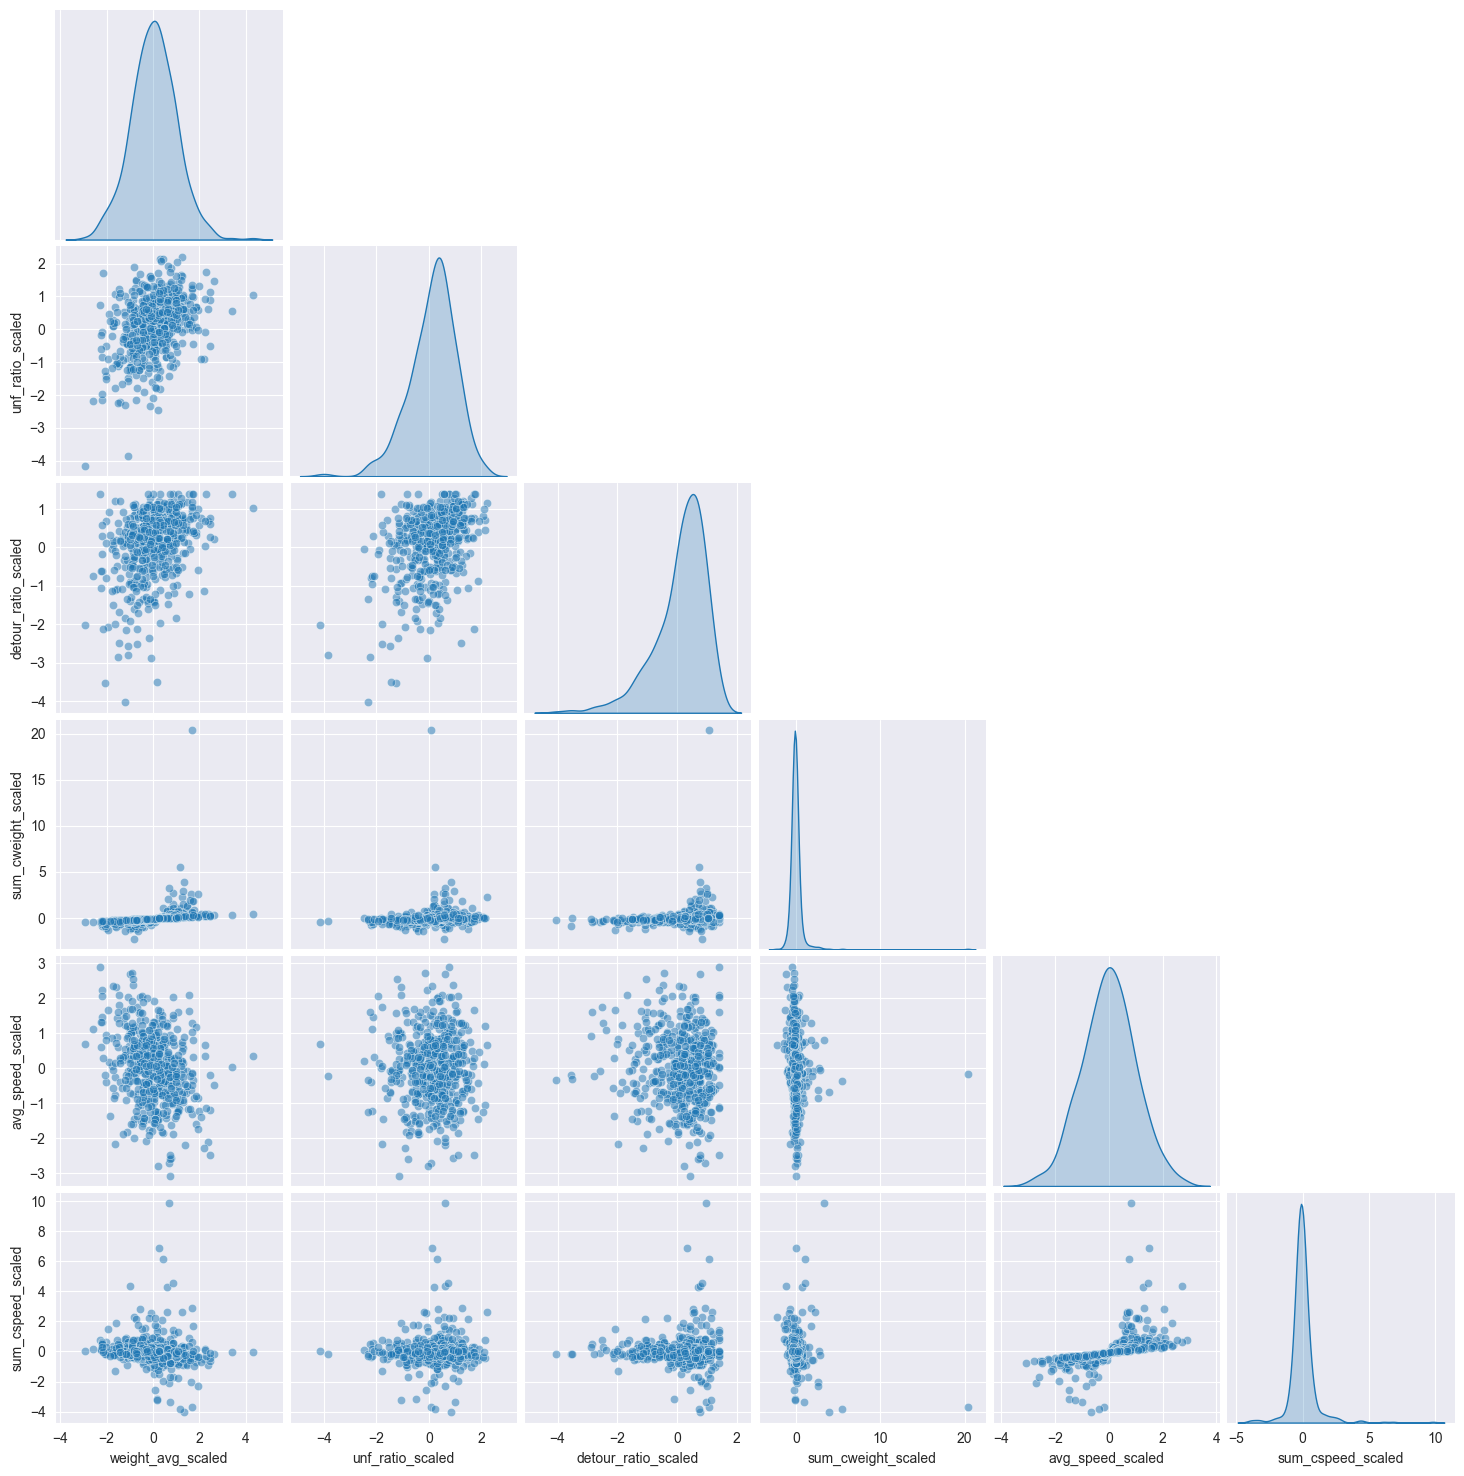

In [7]:
import seaborn as sns

#only consider the scaled vlaues
composite_df_scaled = composite_df[['weight_avg_scaled', 'unf_ratio_scaled', 'detour_ratio_scaled', 'sum_cweight_scaled', 'avg_speed_scaled', 'sum_cspeed_scaled']]

# drop the rows with NaN values
composite_df_scaled = composite_df_scaled.dropna()

# plot correlation of the different sclaed scores in the composite df
sns.pairplot(composite_df_scaled, diag_kind='kde', corner=True, plot_kws={'alpha': 0.5})

**Comment**

In the sum of centered weight and speed scores, there are clear outliers, this is not really a surprise as article that appear a lot more often, can have very large/small values in these scores. Maybe these extreme values should be removed for ML tasks.

There does not appear to be any clear correlation, which is a bit surprising, but also indicates that the different scores are not redundant

## Does PCA Make Sence for combining the scores?
It appears not as the first PC does not capture enough of the variance to exclude the others as the plots below show

In [8]:
from sklearn.decomposition import PCA

# Combine the metrics into one DataFrame
composite_df_pca = pd.DataFrame(index=avg_weight_df.index)
composite_df_pca['weight_avg'] = avg_weight_df['weighted_avg']
composite_df_pca['weight_avg_scaled'] = avg_weight_df['standard']

composite_df_pca['unfinished_ratio'] = unfinished_ratio_df['unfinished_ratio']
composite_df_pca['unf_ratio_scaled'] = unfinished_ratio_df['standard']

composite_df_pca['detour_ratio'] = detour_ratio_df['detour_ratio']
composite_df_pca['detour_ratio_scaled'] = detour_ratio_df['standard']

# Compute composite score using PCA for all three scaled metrics
pca = PCA(n_components=1)
composite_df_pca['comp_score_3'] = pca.fit_transform(
    composite_df_pca[['weight_avg_scaled', 'unf_ratio_scaled', 'detour_ratio_scaled']]
)

# Compute composite score using PCA for only weight_avg_scaled and detour_ratio_scaled
pca = PCA(n_components=1)
composite_df_pca['comp_score_2'] = pca.fit_transform(
    composite_df_pca[['weight_avg_scaled', 'detour_ratio_scaled']]
)

# Sort by the composite score (correct column name)
composite_df_pca = composite_df_pca.sort_values(by='comp_score_3', ascending=False)
composite_df_pca

,weight_avg,weight_avg_scaled,unfinished_ratio,unf_ratio_scaled,detour_ratio,detour_ratio_scaled,comp_score_3,comp_score_2
article,,,,,,,,
Achilles,0.836208,5.047863,0.131148,0.878789,0.000000,1.402347,4.366957,4.893284
J._K._Rowling,0.801971,4.315453,0.117647,1.046548,0.016129,1.015542,3.788728,4.071217
Harry_Potter,0.759035,3.396976,0.155844,0.571906,0.000000,1.402347,3.128517,3.538655
Algebra,0.707719,2.299211,0.060606,1.755347,0.000000,1.402347,3.085579,2.637890
Mercury_(element),0.732165,2.822170,0.053571,1.842760,0.070175,-0.280595,2.603205,2.105063
...,...,...,...,...,...,...,...,...
Sound,0.529081,-1.522212,0.382979,-2.250498,0.177305,-2.849768,-3.831099,-2.928191
Herbivore,0.504138,-2.055789,0.304183,-1.271366,0.205882,-3.535109,-3.978689,-3.757743
Yellowstone_National_Park,0.543211,-1.219945,0.388430,-2.318234,0.226804,-4.036853,-4.287142,-3.358682


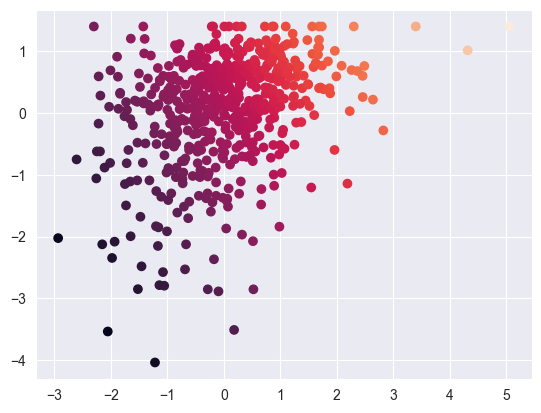

In [9]:
import matplotlib.pyplot as plt

# plot the two scores and the pca score
plt.scatter(composite_df_pca['weight_avg_scaled'], composite_df_pca['detour_ratio_scaled'], c=composite_df_pca['comp_score_2'])

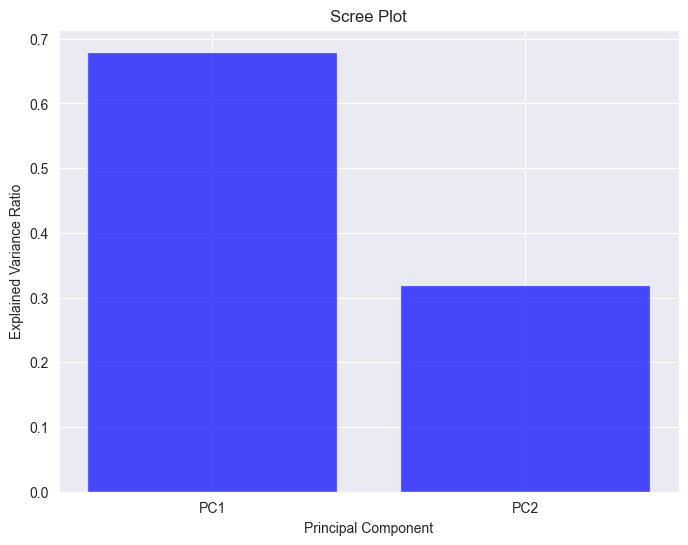

In [10]:
pca = PCA(n_components=2)  # Include all features
pca.fit(composite_df_pca[['weight_avg_scaled', 'detour_ratio_scaled']])#, 'detour_ratio_scaled']])

# Scree plot
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, alpha=0.7, color='b')
plt.xticks(range(1, len(pca.explained_variance_ratio_) + 1), labels=['PC1', 'PC2'])#, 'PC3'])
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()

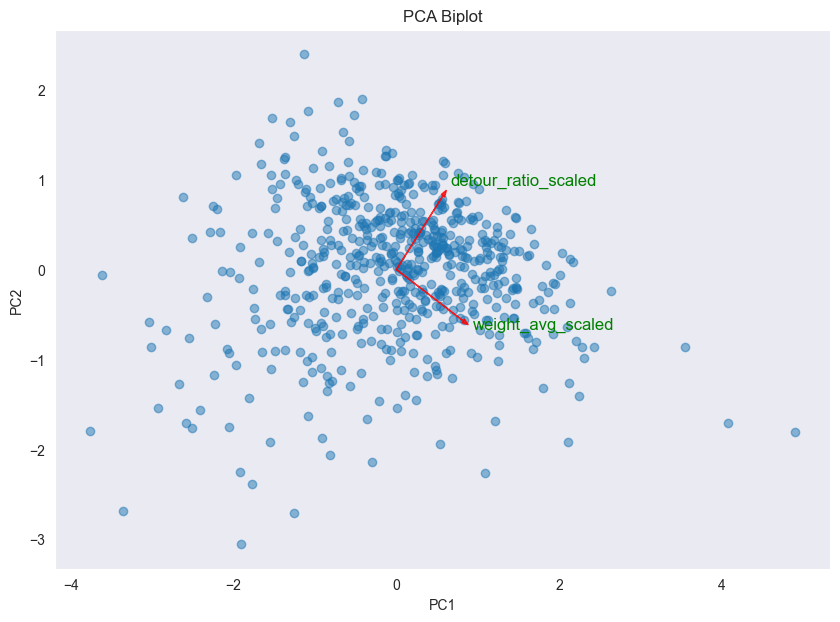

In [11]:
# Standardize the data before PCA
data_scaled = composite_df_pca[['weight_avg_scaled', 'detour_ratio_scaled']] #, 'detour_ratio_scaled']]

# Perform PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(data_scaled)

# Create a biplot
plt.figure(figsize=(10, 7))
plt.scatter(pca_components[:, 0], pca_components[:, 1], alpha=0.5)

# Plot arrows for each original variable
for i, (x, y) in enumerate(zip(pca.components_[0], pca.components_[1])):
    plt.arrow(0, 0, x, y, color='r', alpha=0.8, head_width=0.05)
    plt.text(x * 1.15, y * 1.15, composite_df_pca[['weight_avg_scaled', 'detour_ratio_scaled']].columns[i], color='g', fontsize=12)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Biplot')
plt.grid()
plt.show()

And for 3 scores combined?

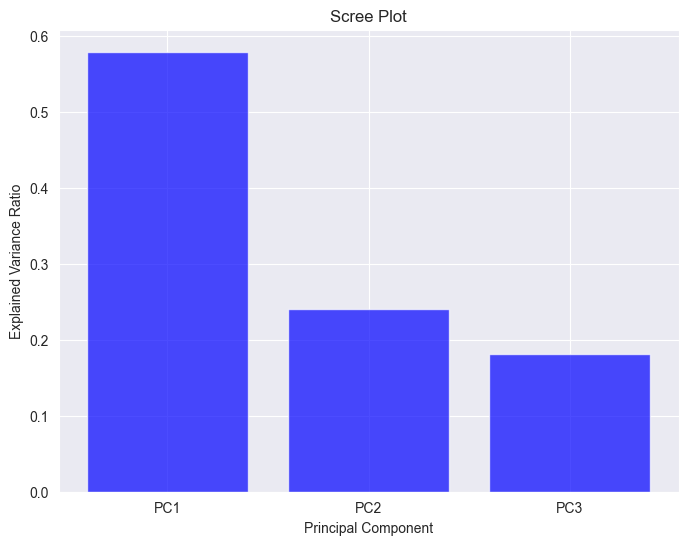

In [12]:
pca = PCA(n_components=3)  # Include all features
pca.fit(composite_df_pca[['weight_avg_scaled', 'unf_ratio_scaled', 'detour_ratio_scaled']])

# Scree plot
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, alpha=0.7, color='b')
plt.xticks(range(1, len(pca.explained_variance_ratio_) + 1), labels=['PC1', 'PC2', 'PC3'])
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()

**Comment**

A rule of thumb is that the first principle component should capture at least 70% of the variance, if we want to use it for our composite scores. In both cases, it is below that, so it is probably not ideal as to much information would be lost in such a dimensionality reduction. 

## Alternative apporach asign weight based on the variance within each score

The Idea is that the larger the variance the more important the score's contribution should be to the composite.
Example with 3 scores:

In [13]:
# Calculate variance-based weights
variances = composite_df[['weight_avg_scaled', 'unf_ratio_scaled', 'detour_ratio_scaled']].var()
weights = variances / variances.sum()

# Weighted average
composite_df['variance_weighted_avg'] = (
    composite_df[['weight_avg_scaled', 'unf_ratio_scaled', 'detour_ratio_scaled']] * weights
).sum(axis=1)

weights

weight_avg_scaled      0.381309
unf_ratio_scaled       0.321945
detour_ratio_scaled    0.296746
dtype: float64

**Comment**

While this is a data driven approach, we beleive that it is not reasonable to assign such a large weight to the unfinished ratio. This is because overall, after filtering the unfinished paths data represents a small fraction of the total filtered data, and there is still no guarante that the player really 'tried' in those attempts.

## Other alternative: Define Custom Weights

This might at first appear quite arbitrary. But the data driven approaches don't appear to make the most sense, and since these scores are defined by us in the first place, it is not so far fetched that we also define how to weight them to get a composite score.

In [14]:
quality_scores_clicks = pd.DataFrame(index=avg_weight_df.index)

# Define custom weights for composite score of 3
weights_3 = {
    'weight_avg_scaled': 0.55,  # Example: 55% importance
    'unf_ratio_scaled': 0.2,  # Example: 20% importance
    'detour_ratio_scaled': 0.25  # Example: 25% importance
}

quality_scores_clicks['composite_3'] = (composite_df[['weight_avg_scaled', 'unf_ratio_scaled', 'detour_ratio_scaled']] * weights_3).sum(axis=1)

# Define custom weights for composite score of 2
weights_2 = {
    'weight_avg_scaled': 0.65,  
    'detour_ratio_scaled': 0.35
}

quality_scores_clicks['composite_2'] = (composite_df[['weight_avg_scaled', 'detour_ratio_scaled']] * weights_2).sum(axis=1)

# Add the PCA scores to the DataFrame (as for combination of two scores the first PC still captured a decent amount of the variance)
quality_scores_clicks['PCA_composite_2'] = composite_df_pca['comp_score_2']

quality_scores_clicks.sort_values(by='composite_3', ascending=False)


,composite_3,composite_2,PCA_composite_2
article,,,
Achilles,3.302669,3.771933,4.893284
J._K._Rowling,2.836694,3.160484,4.071217
Harry_Potter,2.333305,2.698856,3.538655
Algebra,1.966222,1.985309,2.637890
Mercury_(element),1.850597,1.736202,2.105063
...,...,...,...
Sport,-2.051898,-1.664862,-2.514540
Irrigation,-2.057447,-1.957487,-2.618658
Yellowstone_National_Park,-2.143830,-2.205863,-3.358682


Do the same but with the sum of centered weights instead of average weights.

In [15]:
utility_scores_clicks = pd.DataFrame(index=sum_cweight_df.index)

weights_3 = {
    'sum_cweight_scaled': 0.55,  # Example: 55% importance
    'unf_ratio_scaled': 0.2,  # Example: 20% importance
    'detour_ratio_scaled': 0.25  # Example: 25% importance
}

weights_2 = {
    'sum_cweight_scaled': 0.65,  # Example: 55% importance
    'detour_ratio_scaled': 0.35  # Example: 25% importance
}

utility_scores_clicks['composite_3'] = (composite_df[['sum_cweight_scaled', 'unf_ratio_scaled', 'detour_ratio_scaled']] * weights_3).sum(axis=1)
utility_scores_clicks['composite_2'] = (composite_df[['sum_cweight_scaled', 'detour_ratio_scaled']] * weights_2).sum(axis=1)

utility_scores_clicks.sort_values(by='composite_3', ascending=False)


,composite_3,composite_2
article,,
United_States,11.482038,13.613486
United_Kingdom,3.265526,3.844815
World_War_II,2.534867,2.834866
Europe,2.184688,2.488437
Germany,1.967256,2.139464
...,...,...
Country,-1.398636,-1.550083
Actor,-1.568178,-0.981628
Herbivore,-1.588141,-1.769213


And now for the speed.

In [16]:
scores_speed = composite_df[['avg_speed_scaled', 'sum_cspeed_scaled']].dropna().sort_values(by='avg_speed_scaled', ascending=False)
scores_speed

,avg_speed_scaled,sum_cspeed_scaled
article,,
Seawater,2.902291,0.734821
Fresh_water,2.731300,0.649149
Continent,2.705357,4.352900
American_English,2.551665,0.778171
Sunlight,2.379150,0.415360
...,...,...
Democratic_Republic_of_the_Congo,-2.561073,-0.652404
Olympic_Games,-2.590458,-1.666849
Paris,-2.694043,-2.120148


### Finally, store the scores

In [17]:
quality_scores_clicks.to_feather('Data/dataframes/quality_scores_clicks.feather')
utility_scores_clicks.to_feather('Data/dataframes/utility_scores_clicks.feather')
scores_speed.to_feather('Data/dataframes/scores_speed.feather')

## Explanation for the scores to use

**The scores dataframes are saved as feather files, each column is a different score**  

`quality_scores_clicks`: the scores for min number of clicks that rate high article 'quality' in games.
- column composite_3: weighted combined avg_weight, unf_ratio, and detour_ratio scores (after standard scaling)
- column composite_2: weighted combined avg_weight, and detour_ratio scores (after standard scaling)
- column PCA_composite_2: PCA composite score of avg_weight, and detour ratio scores (after standard scaling)

`utility_scores_clicks`: the scores for min number of clicks that rate high article 'utility' in games.
- column composite_3: weighted combined sum_cweight, unf_ratio, and detour_ratio scores (after standard scaling)
- column composite_2: weighted combined sum_cweight, and detour_ratio scores (after standard scaling)

`scores_speed`: the speed related scores.
- column avg_speed_scaled: the average speed scaled
- column sum_cspeed_scaled: the sum of the centered speeds


**NOTE:** the different scores give quite different ratings to articles. So the results of article attribue correlation for the three dataframes are likely very different. (have a look at the correlation plot between the different scores, they are all very uncorrelated...)